# Introduction to the NCAS CF Data Tools, cf-python and cf-plot

***

## Setting up

**In this section we set up this Notebook, import the libraries and check the data we will work with, ready to use the libraries within this notebook.**

Run some set up for nice outputs in this Jupyter Notebook (not required in interactive Python or a script):

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Import cf-python and cf-plot:

In [2]:
import cfplot as cfp
import cf

Inspect the versions of cf-python and cf-plot and the version of the CF Conventions those are matched to:

In [3]:
print("cf-python version is:", cf.__version__)
print("cf-plot version is:", cfp.__version__)
print("CF Conventions version is:", cf.CF())

cf-python version is: 3.18.1
cf-plot version is: 3.4.0
CF Conventions version is: 1.12


<div class="alert alert-block alert-info">
<i>Note:</i> you can work with data compliant by any other version of the CF Conventions, or without (much) compliance, but the CF Conventions version gives the maximum version that these versions of the tools understand the features of.
</div>

Finally, see what datasets we have to explore:

<div class="alert alert-block alert-info">
<i>Note:</i> in a Jupyter Notebook, '!' preceeeds a shell command, so this is a terminal command and not Python
</div>

In [4]:
!ls ../ncas_data

160by320griddata.nc			   precip_2010.nc
aaaaoa.pmh8dec.pp			   precip_DJF_means.nc
alpine_precip_DJF_means.nc		   qbo.nc
data1.nc				   regions.nc
data1-updated.nc			   rgp.nc
data2.nc				   sea_currents_backup.nc
data3.nc				   sea_currents.nc
data5.nc				   ta.nc
ggas2014121200_00-18.nc			   tripolar.nc
IPSL-CM5A-LR_r1i1p1_tas_n96_rcp45_mnth.nc  two_fields.nc
land.nc					   ua.nc
model_precip_DJF_means_low_res.nc	   u_n216.nc
model_precip_DJF_means.nc		   u_n96.nc
n2o_emissions.nc			   vaAMIPlcd_DJF.nc
POLCOMS_WAM_ZUV_01_16012006.nc		   va.nc
precip_1D_monthly.nc			   wapAMIPlcd_DJF.nc
precip_1D_yearly.nc


***

## 6. Changing the underlying grid of data through regridding

**In this section we demonstrate how to change the underlying grid of the data to another grid which could be a higher- or lower- resolution one, or a completely different grid, which is called regridding or interpolation, and indicate various options cf-python supports for doing this.**

### a) Getting a _source_ field ready to regrid

We read in a precipitation field and inspect it:

In [5]:
higher_res_field = cf.read("../ncas_data/precip_2010.nc")[0]
print(higher_res_field)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east


To get a feel for the data we have, let's view a basic subspace as a contour plot. Note we use the `blockfill` argument set to `True` which changes the contour plot to plot the data on a cellular basis rather than filled as smoothed contours (whether or not the contour lines are set to be shown from the `lines` argument, in this case we turn those off too):

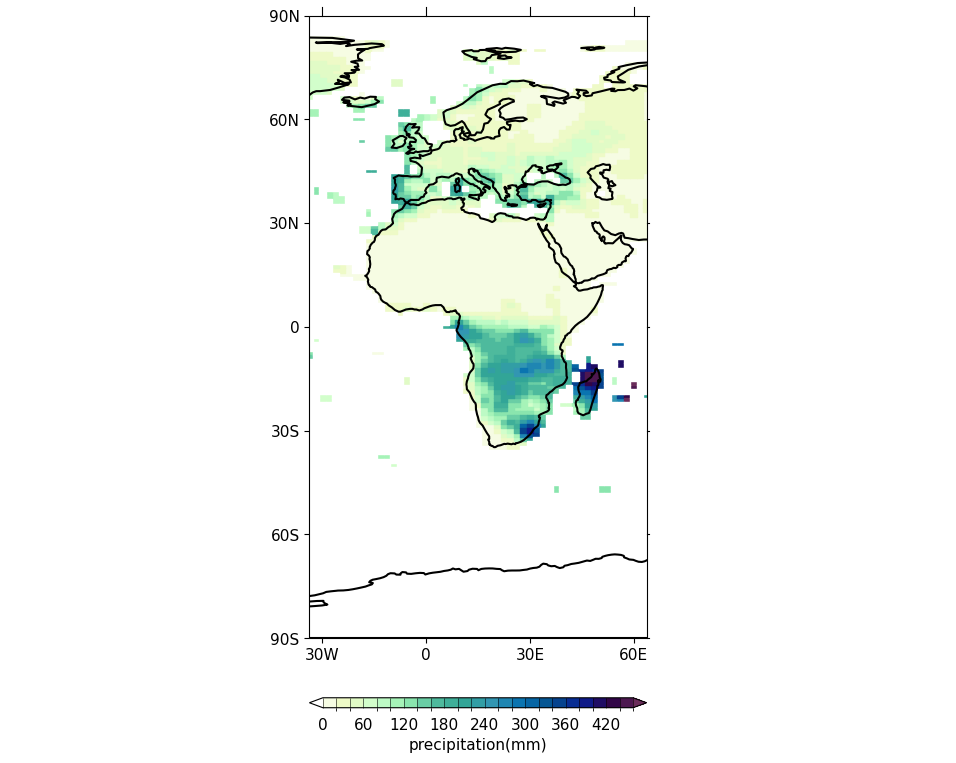

In [6]:
cfp.mapset()  # reset
cfp.cscale("precip_11lev")  # using a colour scale good for precipitation data
cfp.con(higher_res_field[0], blockfill=True, lines=False)

### b) Getting the _destination_ field: another field in order to regrid the previous _onto its grid_

Now we read in another precipitation field and inspect it. The key thing to note is that it is lower resolution than the previous one we read:

In [7]:
lower_res_field = cf.read("../ncas_data/model_precip_DJF_means_low_res.nc")[0]
print(lower_res_field)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


Again, get a feel for the data we have from a view of a basic subspace, to confirm that it is lower resolution (notice the larger cell blocks than before):

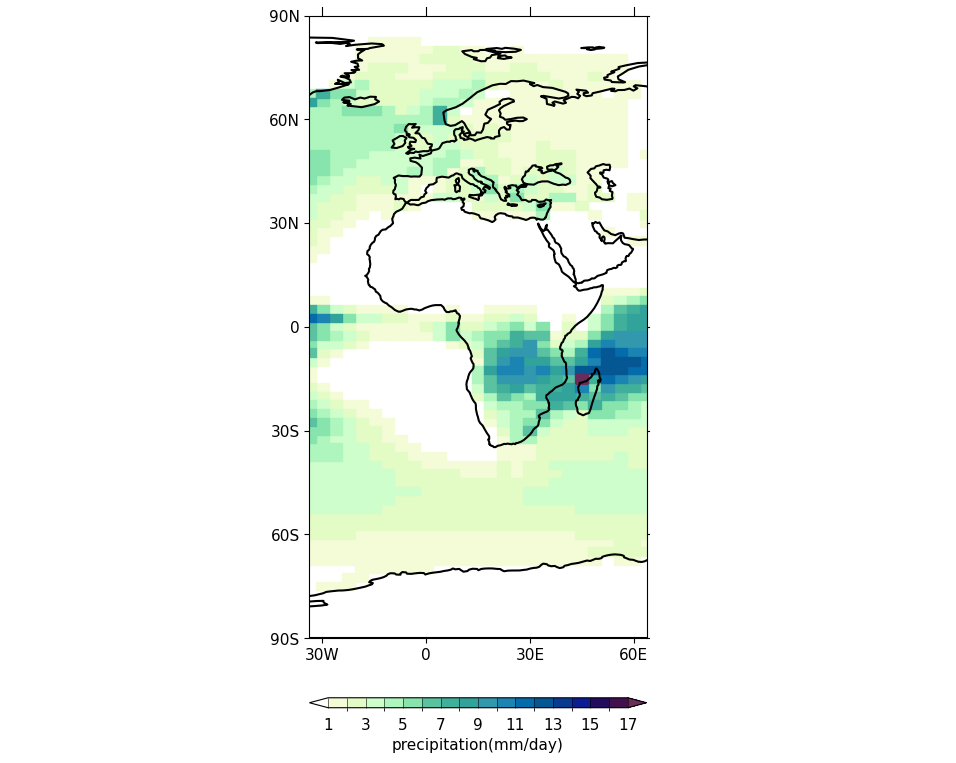

In [8]:
cfp.cscale("precip_11lev")
cfp.con(lower_res_field[0], blockfill=True, lines=False)

### c) Performing the regrid operation from the source to the destination fields

Now the key step after the previous setup: regridding the first (*source*) field to the grid of the second (*destination*) field. We use the `regrids` method of cf-python to do this, where the `s` in the name stands for spherical for spherical regridding, as opposed to Cartesian regridding, also possible with cf-python.

We are going to do two calls, demonstrating two different methods of interpolation, namely the `patch` and `conservative` methods. Assign these to variables so we can compare them next:

In [9]:
patch_regridded_field = higher_res_field.regrids(lower_res_field, method="patch")
conservative_regridded_field = higher_res_field.regrids(lower_res_field, method="conservative")

These two methods do not give the same results!

In [10]:
patch_regridded_field.equals(conservative_regridded_field)

False

Recall how to do field arithmetic. We use subtraction to indicate the difference between the two regridded outcomes which differ only by the interpolation method used to regrid:

In [11]:
difference_field = patch_regridded_field - conservative_regridded_field

### d) Finally, some more advanced cf-plot plotting to compare the source, destination, and regridded results

As with the previous section, let's end by doing more advanced cf-plot plotting to show all of the relevant fields to help us to understand what the regridding did.

Again we are using `gopen` and `gclose` wrapped around our calls to plot. This time we use `gpos` function calls which tell cf-plot exactly where we want to place each plot on the overall canvas. In this case, from our `x` and `y` extrema inputs `xmin`, `xmax`, `ymin` and `ymax`, we are building an effective 4 x 4 grid to place the four contour plots we will show.

There is a lot to take in here, but the main thing is to understand that we use `con` to generate four contour plots corresponding to different stages of our regridding, telling cf-plot to place them at one of the four places in a 4 x 4 grid, with some customisation of colour scales and colour bar levels.

Note here we are taking the [0] index subspace of all of the fields to plot, but we can use any other subspace of the data to view instead:

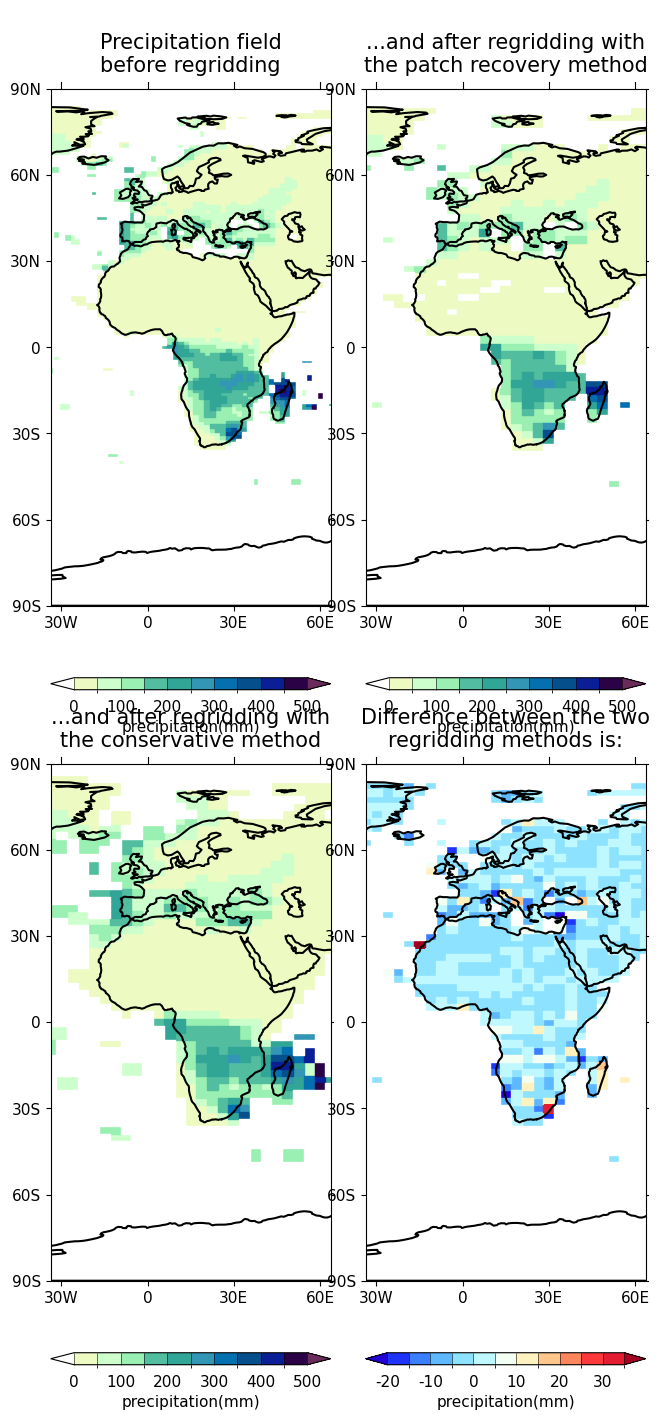

In [12]:
cfp.cscale("viridis")  # reset cmap to perceptually uniform scale
cfp.gopen(rows=2, columns=2, figsize=[7, 15])  #, bottom=0.1, top=0.85)

# Configure first three plots
cfp.mapset()  # reset from previous plots in the notebook - standalone don't need this
cfp.levs(min=0, max=500, step=50)

# First three plots
cfp.gpos(xmin=0.1, xmax=0.5, ymin=0.55, ymax=1.0)
cfp.cscale("precip_11lev")
cfp.con(
    higher_res_field[0], blockfill=True, lines=False,
    title="Precipitation field\nbefore regridding",
)
cfp.gpos(xmin=0.55, xmax=0.95, ymin=0.55, ymax=1.0)
cfp.con(
    patch_regridded_field[0], blockfill=True, lines=False,
    title="...and after regridding with\nthe patch recovery method",
)
cfp.gpos(xmin=0.1, xmax=0.5, ymin=0.1, ymax=0.55)
cfp.con(
    conservative_regridded_field[0], blockfill=True, lines=False,
    title="...and after regridding with\nthe conservative method",
)
cfp.gpos(xmin=0.55, xmax=0.95, ymin=0.1, ymax=0.55)

# This final plot is showing the diff so is a bit different, apply some cf-plot plotting configuration
cfp.levs()
cfp.cscale("BlueDarkRed18")  # is a diff so use a diverging colour map
cfp.con(
    difference_field[0], blockfill=True, lines=False,
    title="Difference between the two\nregridding methods is:",
)
cfp.gclose()

More generally, using regridding with cf-python you can convert from one grid to another very different grid, e.g. from a tripolar to a regular or rotated latitude-longitude grid or vice-versa, including to/from unstructured grids (UGRID grids).

***

## Conclusion and recap of learning objectives

The NCAS CF Data Tools are a suite of Python libraries which are designed to facilitate working with data for research in the earth sciences and aligned domains. We learnt today about the cf-python (https://ncas-cms.github.io/cf-python/) and cf-plot (https://ncas-cms.github.io/cf-plot/build/). The 'cf' in the names of the NCAS CF Data Tools corresponds to the CF Conventions, a metadata standard becoming the de-facto convention across geoscience to cover the description of data so that sharing and intercomparison is simpler.

Our **learning aim** was to be able to use the NCAS CF Data Tools Python libraries, namely cf-python and cf-plot to process, analyse and visualise netCDF and PP datasets, whilst appreciating the context and 'unique selling point' of the libraries as being built to use the CF Conventions, a metadata standard for earth science data, to make it simpler to do what you want to do with the datasets, by working on top of a Data Model for CF.

For our **learning objectives**, we practiced using cf-python and cf-plot to:

* read dataset(s) and view the (meta)data at different detail levels;
* edit the (meta)data and write out the edited version to file;
* reduce datasets by subspacing and collapsing;
* visualise datasets as contour and vector plots;
* analyse data: applying mathematical and statistical operations and plotting trends;
* change the underlying grid of data through regridding.

***

## Where to find more information and resources on the NCAS CF Data Tools

Here are some links relating to the NCAS CF Data Tools and this training.

* This training, with further material, is hosted online and there are instructions for setting up the environment so you can work through it in your own time: https://github.com/NCAS-CMS/cf-tools-training.
* The cf-python documentation lives at https://ncas-cms.github.io/cf-python/.
* The cf-python code lives on GitHub at https://github.com/NCAS-CMS/cf-python. There is an Issue Tracker to report queries or questions at https://github.com/NCAS-CMS/cf-python/issues.
* The cf-plot documentation lives at https://ncas-cms.github.io/cf-plot/build/.
* The cf-plot code lives on GitHub at https://github.com/NCAS-CMS/cf-plot. There is an Issue Tracker to report queries or questions at https://github.com/NCAS-CMS/cf-plot/issues.
* There is a technical presentation about the NCAS CF Data Tools avaialble from https://hps.vi4io.org/_media/events/2020/summer-school-cfnetcdf.pdf.
* The website of the CF Conventions can be found at https://cfconventions.org/.
* The landing page for training into the CF Conventions is found here within the website above: https://cfconventions.org/Training/.

If you have any queries after this course, please either use the Issue Trackers linked above or you can email me at: sadie.bartholomew@ncas.ac.uk.

***